In [1]:
import os
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

In [2]:
# ------------------------------------------------------------------
# Enable multi-threading in TensorFlow
# ------------------------------------------------------------------
os.environ["OMP_NUM_THREADS"] = "20"
os.environ["MKL_NUM_THREADS"] = "20"

# ------------------------------------------------------------------
# 1) Load & Basic Cleaning
# ------------------------------------------------------------------
data_path = "MCM_2025\\2025_MCM-ICM_Problems\\2025_Problem_C_Data\\summerOly_athletes.csv"
df = pd.read_csv(data_path)

# Remove invalid Team entries (digits, decimals, Roman numerals)
df = df[~df['Team'].str.contains(r'\d|\.', na=False)]
roman_pattern = r'(?:\s|-)M{0,4}(?:CM|CD|D?C{0,3})(?:XC|XL|L?X{0,3})(?:IX|IV|V?I{0,3})(?:\s|$)'
df = df[~df['Team'].str.contains(roman_pattern, na=False, flags=re.IGNORECASE)]

# Remove countries not present in the last two Olympics (2020, 2024)
recent_years = [2020, 2024]
df = df[df["NOC"].isin(df[df["Year"].isin(recent_years)]["NOC"].unique())]

# Remove events that appeared <4 times
event_counts = df["Event"].value_counts()
df = df[df["Event"].isin(event_counts[event_counts >= 4].index)]

# Convert Year to int
df["Year"] = pd.to_numeric(df["Year"], errors="coerce").astype(int)

# ------------------------------------------------------------------
# 2) Feature Engineering
# ------------------------------------------------------------------
df["Seed_Player"] = df.groupby("Name")["Medal"].transform(lambda x: (x == "Gold").cumsum() + (x == "Silver").cumsum()).fillna(0).astype(int)
df["Elite_Player"] = df.groupby("Name")["Medal"].transform(lambda x: max(0, (x != "No medal").sum() - 1 + (x == "Gold").sum())).fillna(0).astype(int)
df["Participation_Count"] = df.groupby("Name")["Year"].transform("count")
df["Retiring_Player"] = df["Participation_Count"].apply(lambda x: max(0, x - 3)).astype(int)

host_cities = {2008: "CHN", 2012: "GBR", 2016: "BRA", 2020: "JPN", 2024: "FRA"}
df["Is_Host"] = df.apply(lambda row: 1 if host_cities.get(row['Year'], None) == row['NOC'] else 0, axis=1)

df["NOC"] = df["NOC"].astype(str)
df["Name"] = df["Name"].astype(str)

# ------------------------------------------------------------------
# 3) Aggregation
# ------------------------------------------------------------------
df_num_cols = df.select_dtypes(include=["number"]).columns.difference(["Year"]).tolist()

df_noc_year = (
    df.groupby(["Year", "NOC"], as_index=False)
      .apply(lambda subdf: subdf[df_num_cols].sum(numeric_only=True))
      .reset_index(drop=True)
)

medal_counts = df.groupby(["Year", "NOC"])["Medal"].value_counts().unstack(fill_value=0).reset_index()
medal_columns = {"Gold": "Medal_Gold", "Silver": "Medal_Silver", "Bronze": "Medal_Bronze"}
medal_counts.rename(columns=medal_columns, inplace=True)

df_noc_year = df_noc_year.merge(medal_counts[["Year", "NOC"] + list(medal_columns.values())], on=["Year", "NOC"], how="left")
df_noc_year.fillna(0, inplace=True)

# ------------------------------------------------------------------
# 4) One-Hot Encoding
# ------------------------------------------------------------------
ohe_noc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
encoded_noc = ohe_noc.fit_transform(df_noc_year[["NOC"]])
noc_ohe_cols = [f"NOC_{cat}" for cat in ohe_noc.categories_[0]]

df_noc_year.reset_index(drop=True, inplace=True)
noc_ohe_df = pd.DataFrame(encoded_noc, columns=noc_ohe_cols)
df_noc_year_ohe = pd.concat([df_noc_year.drop(columns=["NOC"]), noc_ohe_df], axis=1)

with open("noc_encoder.pkl", "wb") as f:
    pickle.dump(ohe_noc, f)

# ------------------------------------------------------------------
# 5) Scaling and Splitting Data
# ------------------------------------------------------------------
target_cols = ["Medal_Gold", "Medal_Silver", "Medal_Bronze"]
feature_cols = df_noc_year_ohe.columns.difference(["Year"] + target_cols)

scaler_features = StandardScaler()
scaler_targets = StandardScaler()

X = scaler_features.fit_transform(df_noc_year_ohe[feature_cols])
y = scaler_targets.fit_transform(df_noc_year_ohe[target_cols])

with open("scaler_features.pkl", "wb") as f:
    pickle.dump(scaler_features, f)
with open("scaler_targets.pkl", "wb") as f:
    pickle.dump(scaler_targets, f)

df_noc_year_ohe

C:\Users\Henry Zhu\AppData\Local\Temp\ipykernel_37208\3671893878.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda subdf: subdf[df_num_cols].sum(numeric_only=True))


,Year,Elite_Player,Is_Host,Participation_Count,Retiring_Player,Seed_Player,Medal_Gold,Medal_Silver,Medal_Bronze,NOC_AFG,...,NOC_URU,NOC_USA,NOC_UZB,NOC_VAN,NOC_VEN,NOC_VIE,NOC_VIN,NOC_YEM,NOC_ZAM,NOC_ZIM
0,1896,20,0,25,10,5,2,0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1896,16,0,29,10,2,1,1,2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1896,35,0,132,87,19,1,2,3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1896,30,0,90,22,13,5,4,2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1896,24,0,139,76,12,3,3,3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3092,2024,0,0,41,4,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3093,2024,0,0,5,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3094,2024,0,0,4,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3095,2024,0,0,47,0,0,0,0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [3]:
# ------------------------------------------------------------------
# 6) Model Training with Time Series Cross-Validation
# ------------------------------------------------------------------
def adaptive_lr_schedule(epoch, lr, fold):
    """Dynamically adjust learning rate within and across folds."""
    base_lr = 0.0005
    decay_factor = 0.95
    exploration_boost = 1.05

    if epoch % 10 == 0 and epoch > 0:
        lr *= decay_factor

    if epoch == 0 and fold > 0:
        lr *= exploration_boost

    return max(lr, 1e-9)

def build_medal_prediction_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(2048, activation="swish", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(512, activation="swish", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.2),

        Dense(256, activation="swish", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.2),

        Dense(128, activation="swish"),
        Dropout(0.1),

        Dense(64, activation="swish"),
        Dense(3, activation="linear")  # output: Gold, Silver, Bronze
    ])

    optimizer = AdamW(learning_rate=0.0005, weight_decay=1e-5, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

    return model

def train_and_evaluate(X_train_sc, y_train_sc, X_test_sc, y_test_sc, scaler_targets):
    tscv = TimeSeriesSplit(n_splits=3)
    cv_results = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_sc)):
        print(f"\nTraining on fold {fold + 1}...")

        X_train_fold, X_val_fold = X_train_sc[train_idx], X_train_sc[val_idx]
        y_train_fold, y_val_fold = y_train_sc[train_idx], y_train_sc[val_idx]

        model = build_medal_prediction_model(X_train_fold.shape[1])

        # Learning rate scheduler with fold-aware learning rate boost
        lr_schedule = LearningRateScheduler(lambda epoch, lr: adaptive_lr_schedule(epoch, lr, fold))

        early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)

        history = model.fit(
            X_train_fold, y_train_fold,
            epochs=200,
            batch_size=32,
            validation_data=(X_val_fold, y_val_fold),
            callbacks=[early_stop, reduce_lr, lr_schedule],
            verbose=2
        )

        # Evaluate on validation set
        val_predictions = model.predict(X_val_fold)
        val_mae = np.mean(np.abs(scaler_targets.inverse_transform(val_predictions) - scaler_targets.inverse_transform(y_val_fold)))
        cv_results.append(val_mae)
        print(f"Fold {fold + 1} Validation MAE: {val_mae:.4f}")

    print(f"\nAverage Cross-Validation MAE: {np.mean(cv_results):.4f}")

    return model

def train_final_model(X_train_sc, y_train_sc, X_test_sc, y_test_sc):
    print("\nTraining final model on all data before 2024...")

    final_model = build_medal_prediction_model(X_train_sc.shape[1])

    early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)

    final_history = final_model.fit(
        X_train_sc, y_train_sc,
        epochs=200,
        batch_size=32,
        validation_data=(X_test_sc, y_test_sc),
        callbacks=[early_stop, reduce_lr],
        verbose=2
    )

    return final_model

def predict_olympic_medals_2024(model, X_all, y_all, scaler_targets, df_noc_year_ohe, original_df):
    """
    Predict medal counts for the 2024 Olympics and evaluate performance.
    """

    X_2024_sc = X_all[df_noc_year_ohe["Year"] == 2024]
    y_2024 = y_all[df_noc_year_ohe["Year"] == 2024].reset_index(drop=True)
    df_2024_original = original_df[original_df["Year"] == 2024].reset_index(drop=True)

    noc_values = df_2024_original["NOC"].values

    preds_2024_sc = model.predict(X_2024_sc)
    preds_2024 = scaler_targets.inverse_transform(preds_2024_sc)

    if len(noc_values) != len(preds_2024) or len(noc_values) != len(y_2024):
        raise ValueError("Mismatch in lengths of NOC values, predictions, or actual values.")

    df_results = pd.DataFrame({
        "NOC": noc_values,
        "Gold_Actual": y_2024["Medal_Gold"].values,
        "Silver_Actual": y_2024["Medal_Silver"].values,
        "Bronze_Actual": y_2024["Medal_Bronze"].values,
        "Gold_Predicted": preds_2024[:, 0],
        "Silver_Predicted": preds_2024[:, 1],
        "Bronze_Predicted": preds_2024[:, 2],
    })

    # Calculate percentage error
    df_results["Gold_Error_%"] = abs(df_results["Gold_Predicted"] - df_results["Gold_Actual"]) / (df_results["Gold_Actual"].replace(0, np.nan)) * 100
    df_results["Silver_Error_%"] = abs(df_results["Silver_Predicted"] - df_results["Silver_Actual"]) / (df_results["Silver_Actual"].replace(0, np.nan)) * 100
    df_results["Bronze_Error_%"] = abs(df_results["Bronze_Predicted"] - df_results["Bronze_Actual"]) / (df_results["Bronze_Actual"].replace(0, np.nan)) * 100

    df_results.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_results.fillna(0, inplace=True)

    print("\n2024 Prediction Results:")
    print(df_results)

    return df_results

In [4]:
# Perform cross-validation training
model = train_and_evaluate(X, y, X, y, scaler_targets)

# Train final model on all available data before 2024
final_model = train_final_model(X, y, X, y)

# Predict medals for the 2024 Olympics
predicted_result_2024 = predict_olympic_medals_2024(
    final_model,
    X,
    df_noc_year_ohe[target_cols],
    scaler_targets,
    df_noc_year_ohe,
    df_noc_year
)


Training on fold 1...
Epoch 1/200
25/25 - 2s - 74ms/step - loss: 15.4770 - mae: 0.6807 - val_loss: 14.1678 - val_mae: 0.4253 - learning_rate: 5.0000e-04
Epoch 2/200
25/25 - 0s - 10ms/step - loss: 13.5164 - mae: 0.5352 - val_loss: 12.7369 - val_mae: 0.3989 - learning_rate: 5.0000e-04
Epoch 3/200
25/25 - 0s - 10ms/step - loss: 12.1852 - mae: 0.4849 - val_loss: 11.5948 - val_mae: 0.3913 - learning_rate: 5.0000e-04
Epoch 4/200
25/25 - 0s - 11ms/step - loss: 11.0363 - mae: 0.4516 - val_loss: 10.6597 - val_mae: 0.4019 - learning_rate: 5.0000e-04
Epoch 5/200
25/25 - 0s - 11ms/step - loss: 10.1790 - mae: 0.4533 - val_loss: 9.6397 - val_mae: 0.3564 - learning_rate: 5.0000e-04
Epoch 6/200
25/25 - 0s - 10ms/step - loss: 9.2142 - mae: 0.4207 - val_loss: 8.8126 - val_mae: 0.3511 - learning_rate: 5.0000e-04
Epoch 7/200
25/25 - 0s - 10ms/step - loss: 8.3313 - mae: 0.3925 - val_loss: 8.0353 - val_mae: 0.3447 - learning_rate: 5.0000e-04
Epoch 8/200
25/25 - 0s - 11ms/step - loss: 7.6087 - mae: 0.3948 -

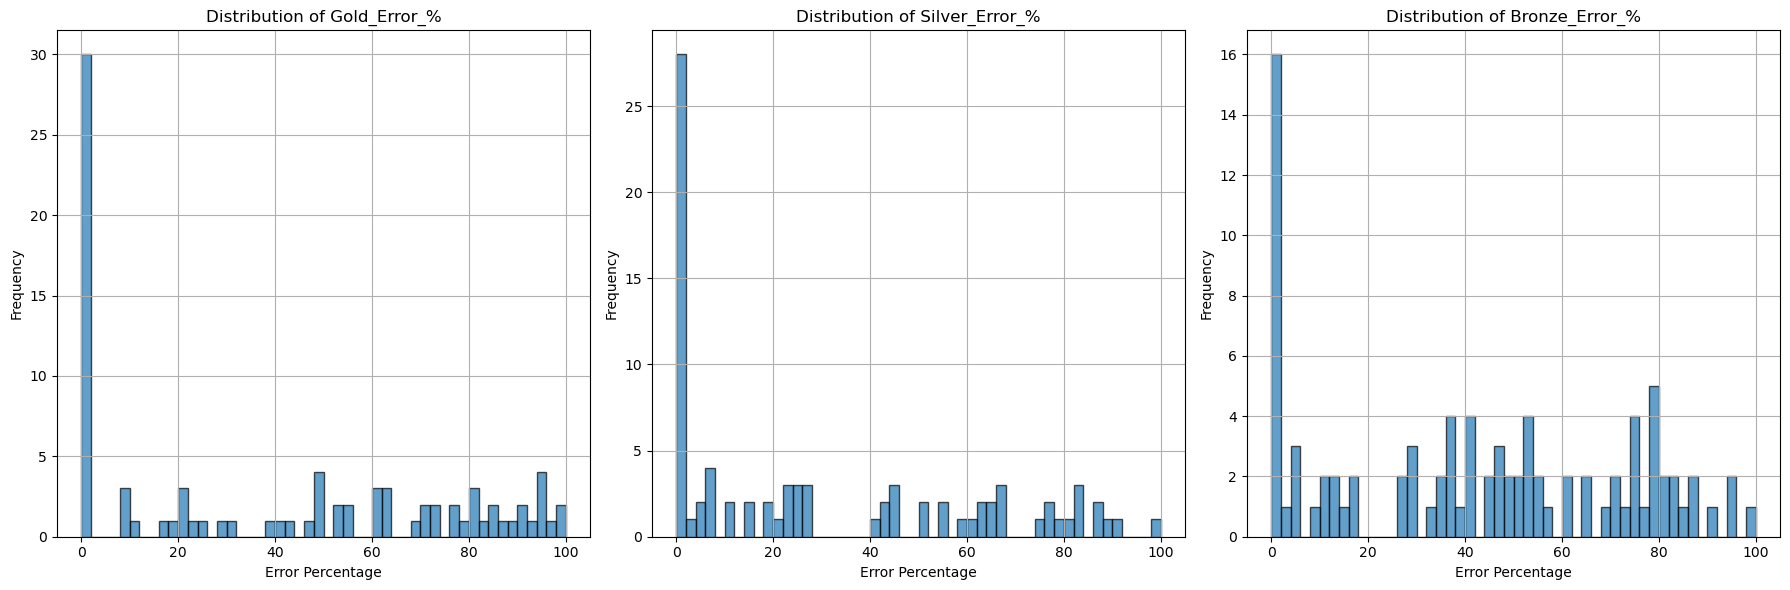

Percentage of data points exceeding 100% error (ignoring zero actual values):
Gold_Error_%      5.434783
Silver_Error_%    9.782609
Bronze_Error_%    2.173913
dtype: float64


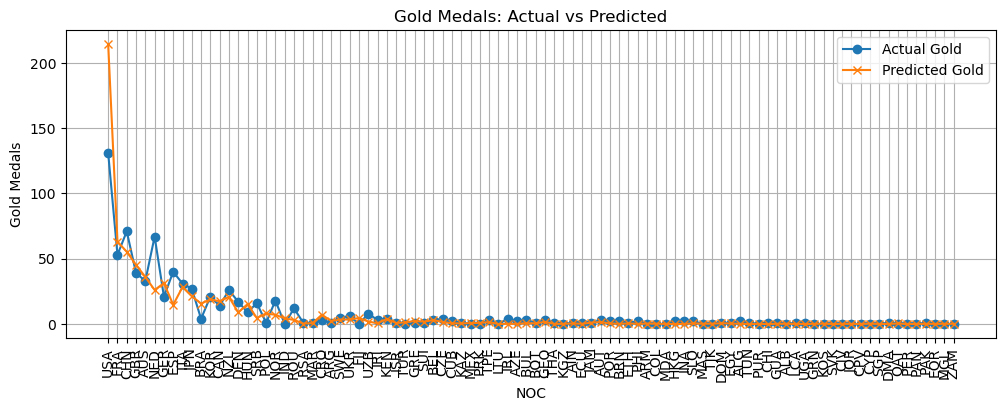

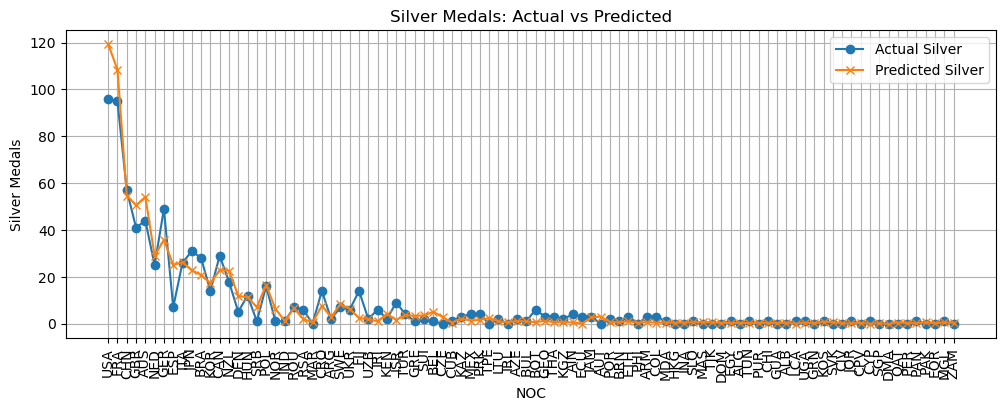

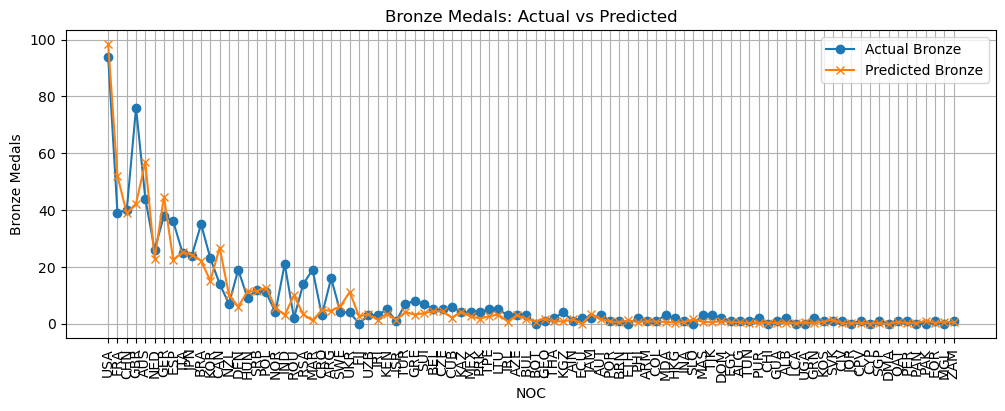

Gold Medal MAE: 3.87
Silver Medal MAE: 2.72
Bronze Medal MAE: 3.26


In [5]:
# Define error columns
error_cols = ["Gold_Error_%", "Silver_Error_%", "Bronze_Error_%"]

# Filter out rows where the actual medal count is zero to avoid skewed results
filtered_results = predicted_result_2024[
    (predicted_result_2024["Gold_Actual"] > 0) |
    (predicted_result_2024["Silver_Actual"] > 0) |
    (predicted_result_2024["Bronze_Actual"] > 0)
]

# Plot histograms for each error column, restricted to 0-100 range
plt.figure(figsize=(18, 6))

for i, col in enumerate(error_cols):
    plt.subplot(1, 3, i + 1)
    plt.hist(filtered_results[col], bins=50, range=(0, 100), edgecolor='black', alpha=0.7)
    plt.title(f"Distribution of {col}")
    plt.xlabel("Error Percentage")
    plt.ylabel("Frequency")
    plt.grid(True)

plt.tight_layout()
plt.show()

# Calculate the percentage of data points exceeding 100% error, ignoring zero actual values
exceed_100 = (filtered_results[error_cols] > 100).sum() / len(filtered_results) * 100

print("Percentage of data points exceeding 100% error (ignoring zero actual values):")
print(exceed_100)

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Filter rows with non-zero actual medal counts
non_zero_df = predicted_result_2024[
    (predicted_result_2024["Gold_Actual"] > 0) |
    (predicted_result_2024["Silver_Actual"] > 0) |
    (predicted_result_2024["Bronze_Actual"] > 0)
].copy()

# Sort by decreasing total actual medal counts
non_zero_df["Total_Actual"] = (
    non_zero_df["Gold_Actual"] + non_zero_df["Silver_Actual"] + non_zero_df["Bronze_Actual"]
)
non_zero_df = non_zero_df.sort_values(by="Total_Actual", ascending=False)

# Extract data for plotting
nocs = non_zero_df["NOC"]
gold_actual = non_zero_df["Gold_Actual"]
gold_predicted = non_zero_df["Gold_Predicted"]

silver_actual = non_zero_df["Silver_Actual"]
silver_predicted = non_zero_df["Silver_Predicted"]

bronze_actual = non_zero_df["Bronze_Actual"]
bronze_predicted = non_zero_df["Bronze_Predicted"]

# Plot Gold medals
plt.figure(figsize=(12, 4))
plt.plot(nocs, gold_actual, label="Actual Gold", marker='o')
plt.plot(nocs, gold_predicted, label="Predicted Gold", marker='x')
plt.xlabel("NOC")
plt.ylabel("Gold Medals")
plt.title("Gold Medals: Actual vs Predicted")
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

# Plot Silver medals
plt.figure(figsize=(12, 4))
plt.plot(nocs, silver_actual, label="Actual Silver", marker='o')
plt.plot(nocs, silver_predicted, label="Predicted Silver", marker='x')
plt.xlabel("NOC")
plt.ylabel("Silver Medals")
plt.title("Silver Medals: Actual vs Predicted")
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

# Plot Bronze medals
plt.figure(figsize=(12, 4))
plt.plot(nocs, bronze_actual, label="Actual Bronze", marker='o')
plt.plot(nocs, bronze_predicted, label="Predicted Bronze", marker='x')
plt.xlabel("NOC")
plt.ylabel("Bronze Medals")
plt.title("Bronze Medals: Actual vs Predicted")
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

# Calculate MAE for each medal type
gold_mae = mean_absolute_error(gold_actual, gold_predicted)
silver_mae = mean_absolute_error(silver_actual, silver_predicted)
bronze_mae = mean_absolute_error(bronze_actual, bronze_predicted)

print(f"Gold Medal MAE: {gold_mae:.2f}")
print(f"Silver Medal MAE: {silver_mae:.2f}")
print(f"Bronze Medal MAE: {bronze_mae:.2f}")

In [10]:
df = pd.read_csv("MCM_2025\\2025_MCM-ICM_Problems\\2025_Problem_C_Data\\summerOly_athletes.csv")

# Clean data
df = df[~df['Team'].str.contains(r'\d|\.', na=False)]
roman_pattern = r'(?:\s|-)M{0,4}(?:CM|CD|D?C{0,3})(?:XC|XL|L?X{0,3})(?:IX|IV|V?I{0,3})(?:\s|$)'
df = df[~df['Team'].str.contains(roman_pattern, na=False, flags=re.IGNORECASE)]

recent_years = [2020, 2024]
df = df[df["NOC"].isin(df[df["Year"].isin(recent_years)]["NOC"].unique())]

# Feature Engineering
df["Seed_Player"] = df.groupby("Name")["Medal"].transform(lambda x: (x == "Gold").cumsum() + (x == "Silver").cumsum()).fillna(0).astype(int)
df["Elite_Player"] = df.groupby("Name")["Medal"].transform(lambda x: max(0, (x != "No medal").sum() - 1 + (x == "Gold").sum())).fillna(0).astype(int)
df["Participation_Count"] = df.groupby("Name")["Year"].transform("count")
df["Retiring_Player"] = df["Participation_Count"].apply(lambda x: max(0, x - 3)).astype(int)

host_cities = {2008: "CHN", 2012: "GBR", 2016: "BRA", 2020: "JPN", 2024: "FRA"}
df["Is_Host"] = df.apply(lambda row: 1 if host_cities.get(row['Year'], None) == row['NOC'] else 0, axis=1)

df["Year"] = df["Year"].astype(int)

# Aggregation by NOC and Year
df_num_cols = df.select_dtypes(include=["number"]).columns.difference(["Year"]).tolist()
df_noc_year = (
    df.groupby(["Year", "NOC"], as_index=False)
      .apply(lambda subdf: subdf[df_num_cols].sum(numeric_only=True))
      .reset_index(drop=True)
)

medal_counts = df.groupby(["Year", "NOC"])["Medal"].value_counts().unstack(fill_value=0).reset_index()
medal_counts.rename(columns={"Gold": "Medal_Gold", "Silver": "Medal_Silver", "Bronze": "Medal_Bronze"}, inplace=True)
df_noc_year = df_noc_year.merge(medal_counts, on=["Year", "NOC"], how="left").fillna(0)

# One-Hot Encoding NOC
ohe_noc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
encoded_noc = ohe_noc.fit_transform(df_noc_year[["NOC"]])
noc_ohe_cols = [f"NOC_{cat}" for cat in ohe_noc.categories_[0]]

df_noc_year.reset_index(drop=True, inplace=True)
noc_ohe_df = pd.DataFrame(encoded_noc, columns=noc_ohe_cols)
df_noc_year_ohe = pd.concat([df_noc_year.drop(columns=["NOC"]), noc_ohe_df], axis=1)

# Save the encoder
with open("noc_encoder.pkl", "wb") as f:
    pickle.dump(ohe_noc, f)

# Scaling and Splitting Data
target_cols = ["Medal_Gold", "Medal_Silver", "Medal_Bronze"]
feature_cols = df_noc_year_ohe.columns.difference(["Year"] + target_cols)

scaler_features = StandardScaler()
scaler_targets = StandardScaler()

X = scaler_features.fit_transform(df_noc_year_ohe[feature_cols])
y = scaler_targets.fit_transform(df_noc_year_ohe[target_cols])

# Save scalers
with open("scaler_features.pkl", "wb") as f:
    pickle.dump(scaler_features, f)
with open("scaler_targets.pkl", "wb") as f:
    pickle.dump(scaler_targets, f)

# Model Training
def build_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(2048, activation="swish"),
        BatchNormalization(),
        Dropout(0.3),
        Dense(512, activation="swish"),
        BatchNormalization(),
        Dropout(0.2),
        Dense(256, activation="swish"),
        BatchNormalization(),
        Dropout(0.2),
        Dense(128, activation="swish"),
        Dropout(0.1),
        Dense(64, activation="swish"),
        Dense(3, activation="linear")
    ])
    optimizer = AdamW(learning_rate=0.0005, weight_decay=1e-5)
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
    return model

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train model
model_2028 = build_model(X_train.shape[1])
early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)

model_2028.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop, reduce_lr])

# Step 1: Prepare 2028 Data
df_2028 = df_noc_year_ohe[df_noc_year_ohe["Year"] == 2024].copy()
df_2028["Year"] = 2028
df_2028["Is_Host"] = df_2028["NOC_USA"]

historical_data = df_noc_year_ohe[df_noc_year_ohe["Year"] >= (2028 - 24)].copy()
feature_dfs = {}

for feature in feature_cols:
    grouped = historical_data.groupby(["Year"] + noc_ohe_cols, as_index=False)[feature].sum()
    grouped["NOC"] = grouped[noc_ohe_cols].idxmax(axis=1).str.replace("NOC_", "")
    grouped.drop(columns=noc_ohe_cols, inplace=True)
    feature_df = grouped.pivot(index="NOC", columns="Year", values=feature).fillna(0)
    feature_dfs[feature] = feature_df
    feature_df["Baseline_2028"] = feature_df.iloc[:, -3:].mean(axis=1)

for feature, values in feature_dfs.items():
    for noc, value in values["Baseline_2028"].items():
        noc_col = f"NOC_{noc}"
        if noc_col in df_2028.columns:
            df_2028.loc[df_2028[noc_col] == 1, feature] = value

for col in df_noc_year_ohe.columns:
    if col not in df_2028.columns:
        df_2028[col] = 0

X_2028 = df_2028[feature_cols].values
preds_2028 = model_2028.predict(X_2028)

df_results_2028 = pd.DataFrame({
    "NOC": df_noc_year[df_noc_year["Year"] == 2024]["NOC"].values,
    "Gold_Predicted": preds_2028[:, 0],
    "Silver_Predicted": preds_2028[:, 1],
    "Bronze_Predicted": preds_2028[:, 2],
})

print("\nPredicted medal counts for 2028:")
print(df_results_2028.head())


Training final model on all data before 2024...
Epoch 1/200
97/97 - 2s - 25ms/step - loss: 13.5790 - mae: 0.5095 - val_loss: 11.5514 - val_mae: 0.4038 - learning_rate: 5.0000e-04
Epoch 2/200
97/97 - 1s - 9ms/step - loss: 9.4006 - mae: 0.3801 - val_loss: 7.8609 - val_mae: 0.3403 - learning_rate: 5.0000e-04
Epoch 3/200
97/97 - 1s - 9ms/step - loss: 6.3209 - mae: 0.3397 - val_loss: 5.1050 - val_mae: 0.2576 - learning_rate: 5.0000e-04
Epoch 4/200
97/97 - 1s - 9ms/step - loss: 4.2836 - mae: 0.3188 - val_loss: 3.6676 - val_mae: 0.2853 - learning_rate: 5.0000e-04
Epoch 5/200
97/97 - 1s - 9ms/step - loss: 3.0028 - mae: 0.3045 - val_loss: 2.4700 - val_mae: 0.2271 - learning_rate: 5.0000e-04
Epoch 6/200
97/97 - 1s - 9ms/step - loss: 2.2190 - mae: 0.3026 - val_loss: 1.8568 - val_mae: 0.2170 - learning_rate: 5.0000e-04
Epoch 7/200
97/97 - 1s - 9ms/step - loss: 1.7036 - mae: 0.2853 - val_loss: 1.5417 - val_mae: 0.2244 - learning_rate: 5.0000e-04
Epoch 8/200
97/97 - 1s - 9ms/step - loss: 1.3633 - m

C:\Users\Henry Zhu\AppData\Local\Temp\ipykernel_37208\2226802629.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historical_data["NOC"] = historical_data[noc_columns].idxmax(axis=1).str.replace("NOC_", "")


KeyError: 2028